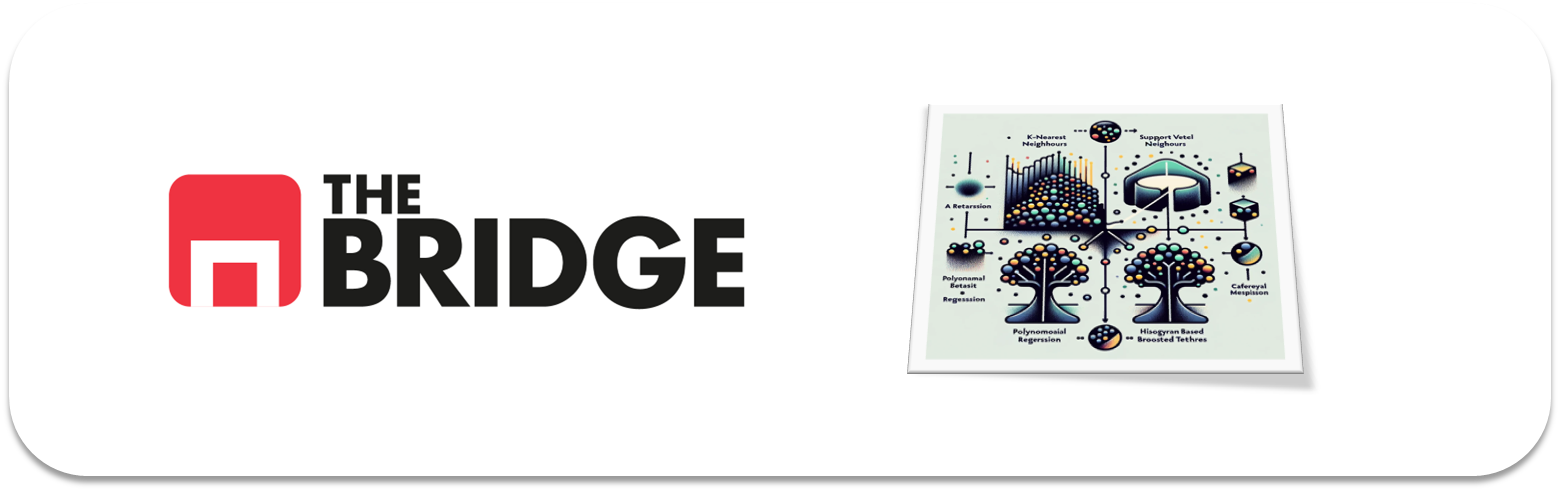

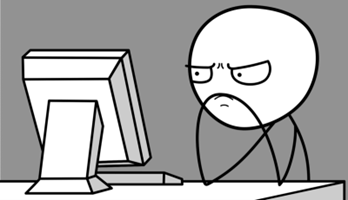

Para hacer un **repaso a los problemas de clasificacion con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Equilibrado del train set  
10. Evaluación contra test.  
11. Análisis de errores, posibles acciones futuras.  
12. EXTRA: Persistencia del modelo en disco.  

### El problema

La unidad oncológica del hospital de Madison, Wisconsin, está trabajando en un tratamiento muy prometedor sobre el cáncer de mama. Desgraciadamente es un tratamiento con efectos secundarios y todavía excesivamente caro, pero cuya efectividad es extraordinaria si se aplica en las primeras etpas o incluso antes de haberlo desarrollado. 

En este sentido, la univeridad quiere disponer de un modelo que le permita detectar potenciales pacientes pero con un alto nivel de acierto en detectar quien puede tener cáncer para no aplicar el tratamiento a personas que no fueran a desarrollarlo y por tanto no sólo perder dinero, sino también, y más importante causar problemas a esas personas. 

Nos piden trabajar sobre datos que ya tienen, y que pueden obtener facilmente de cualquier futuro aspirante a las pruebas y ensayos con el tratamiento, de pacientes que desarrollaron y no el cáncer. Sobre ese dataset quieren que les proporcionemos el mejor modelo de predicción de quién desarrollará o no el cáncer y que cumpla con las expectativas del párrafo anterior.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué tipo de problema de clasificación vamos a resolver? ¿Qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

Problema de clasificación binario, donde el valor = (no desarrolla cancer) y 1(desarrollará cáncer) cuyas métricas a valorar van a ser el accuracy, la precisión y sobre todo la sensibilidad (recall) para evitar falsos negativos.

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [2]:
df = pd.read_csv('./data/wisconsin_cancer.csv', sep="|")
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    object 
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
 11  radius_se               569 non-null    float64
 12  texture_se              569 non-null    float64
 13  perimeter_se            569 non-null    float64
 14  area_se                 569 non-null    fl

In [4]:
df.columns = [col.replace(" ", "_") for col in df.columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    object 
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave_points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
 11  radius_se               569 non-null    float64
 12  texture_se              569 non-null    float64
 13  perimeter_se            569 non-null    float64
 14  area_se                 569 non-null    fl

NOTA: Para más información sobre el dataset el hospital nos redirige a esta [página web](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download)

### Ejercicio 3: Split

Haz el split en train y test.

In [6]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
target = 'diagnosis'

### Ejercicio 4: MiniEDA (I)

Analiza la distribución frecuencial de target brevemente.

<Axes: xlabel='diagnosis', ylabel='count'>

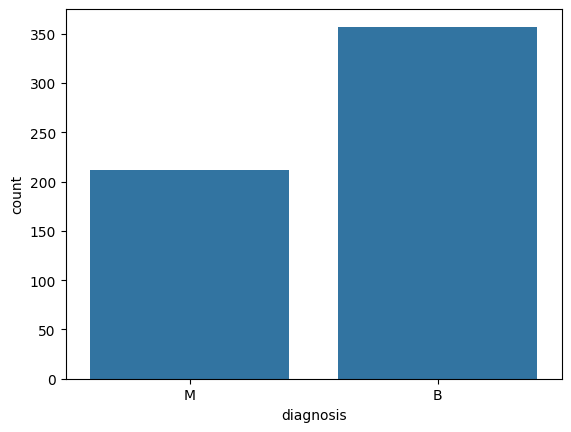

In [8]:
sns.countplot(data = df, x= 'diagnosis')

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, de forma que veamos las distintas distribuciones para cada clase (puedes emplear la libería gráfica que crees conveniente)

In [9]:
features_num = df.columns.to_list()
features_num.remove('diagnosis')
features_num

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave_points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave_points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst']

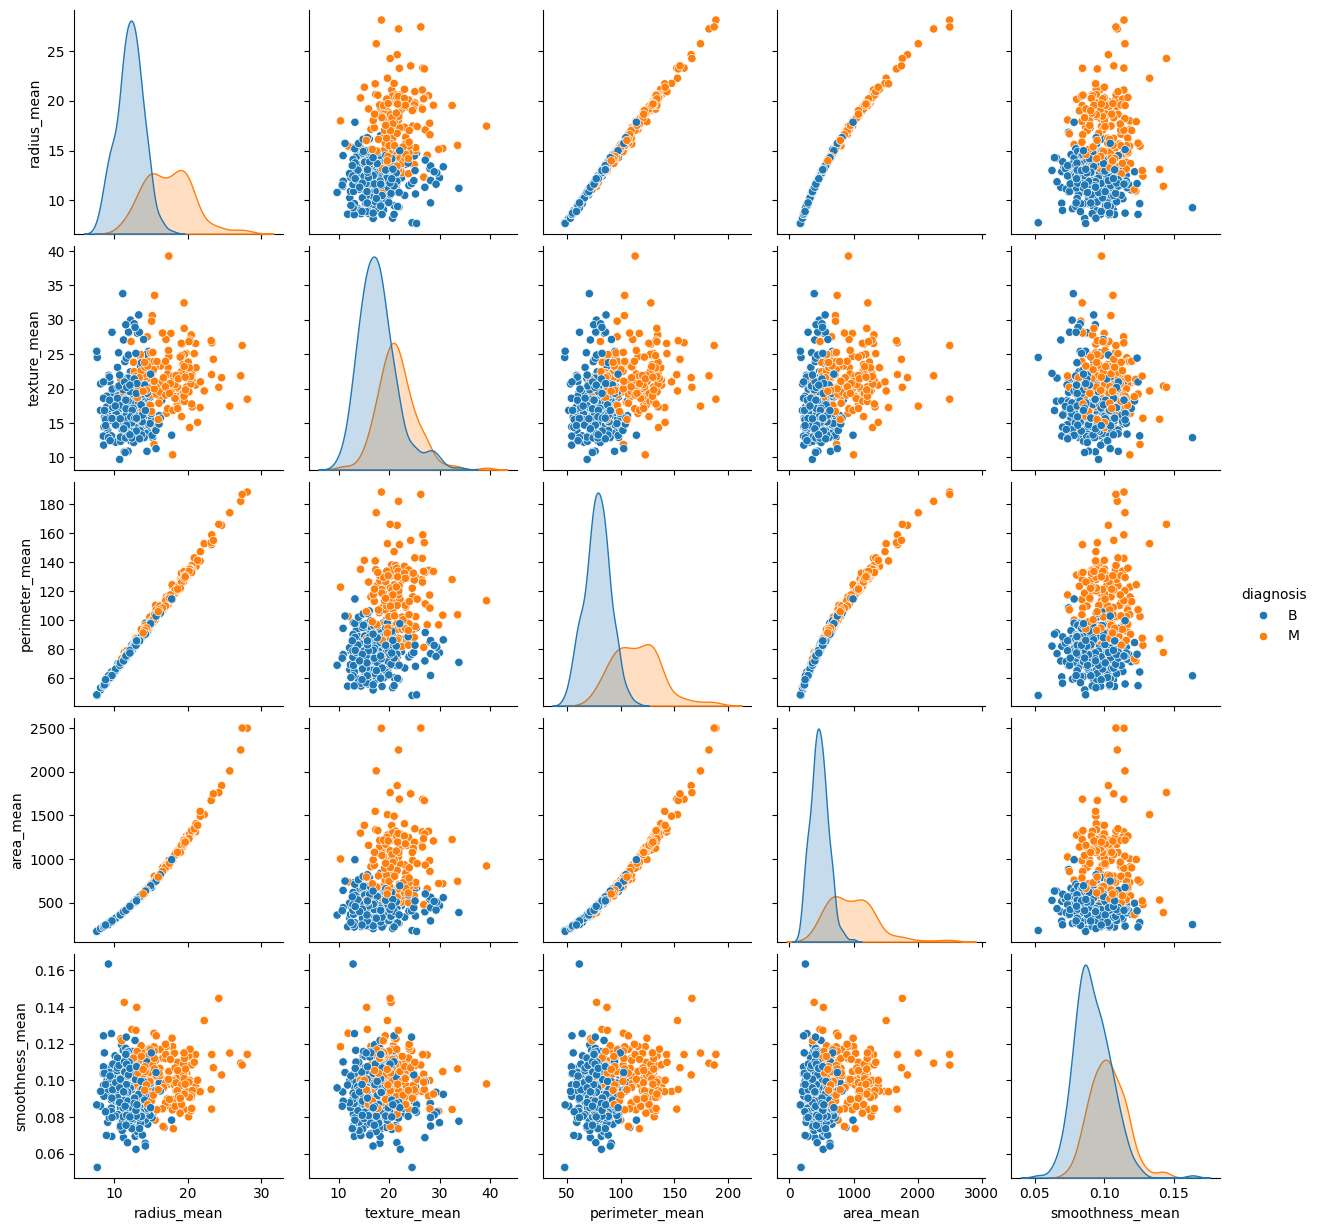

In [10]:
sns.pairplot(train_set[features_num[0:5] + [target]], hue = target)

In [11]:
to_investigate_1 = ['radius_mean', 'area_mean', 'perimeter_mean']

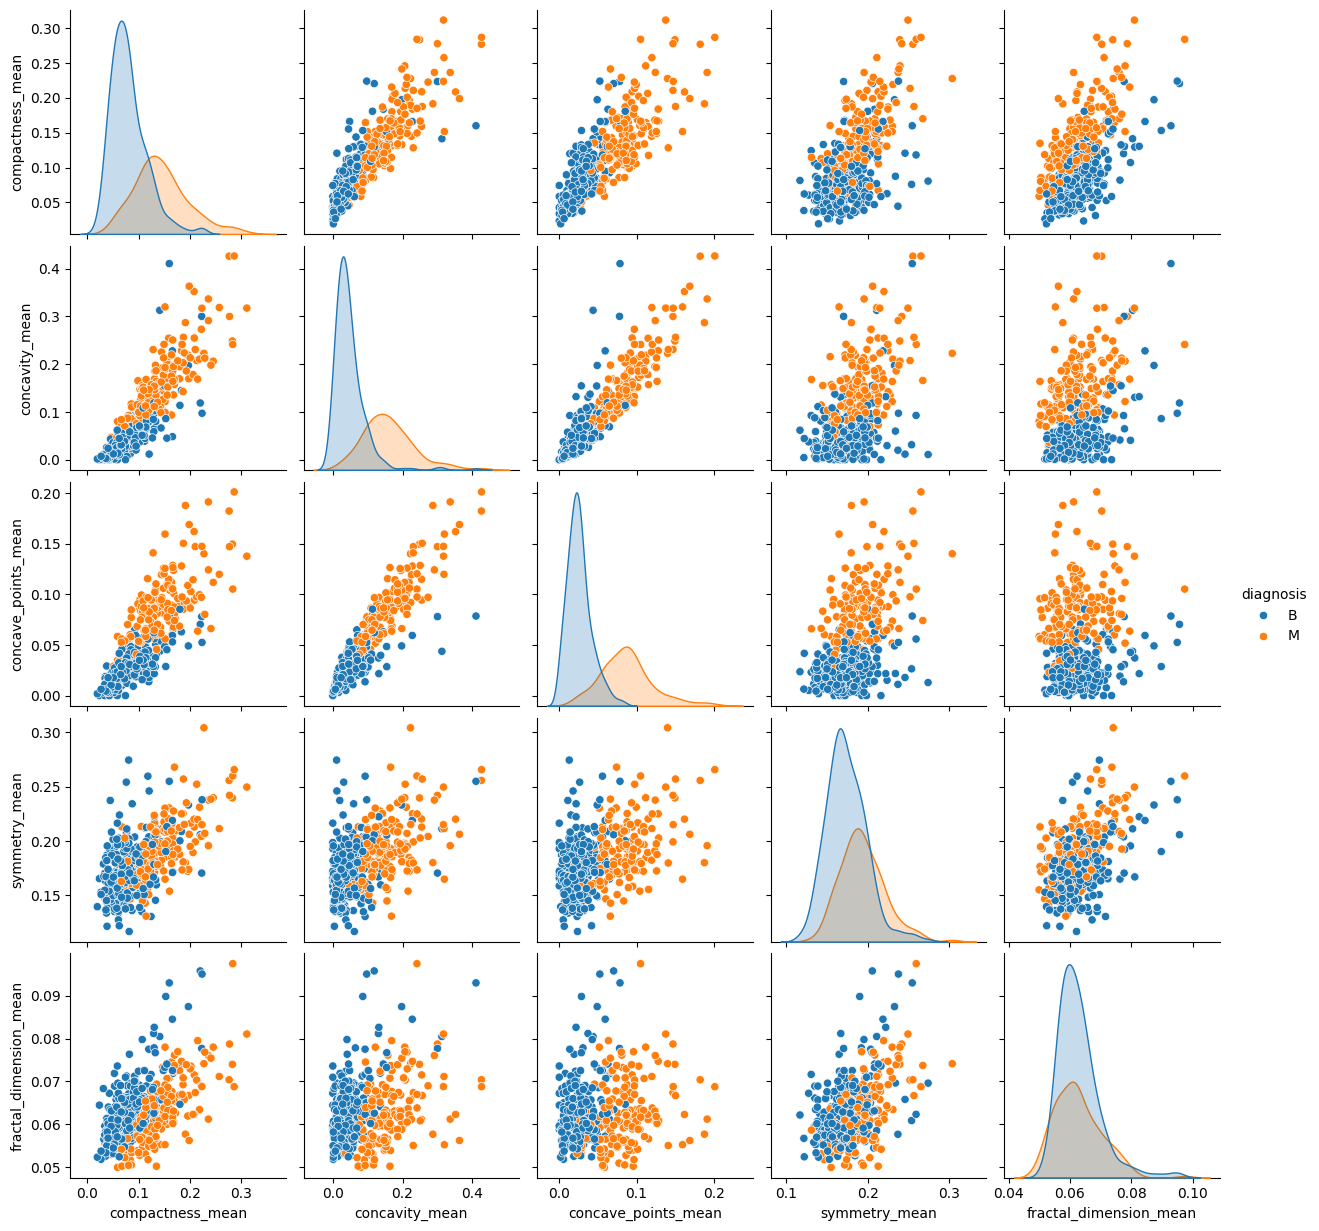

In [12]:
sns.pairplot(train_set[features_num[5:10] + [target]], hue = target)

In [13]:
to_investigate_2 = ['compactness_mean','concavity_mean', 'concave_points_mean']

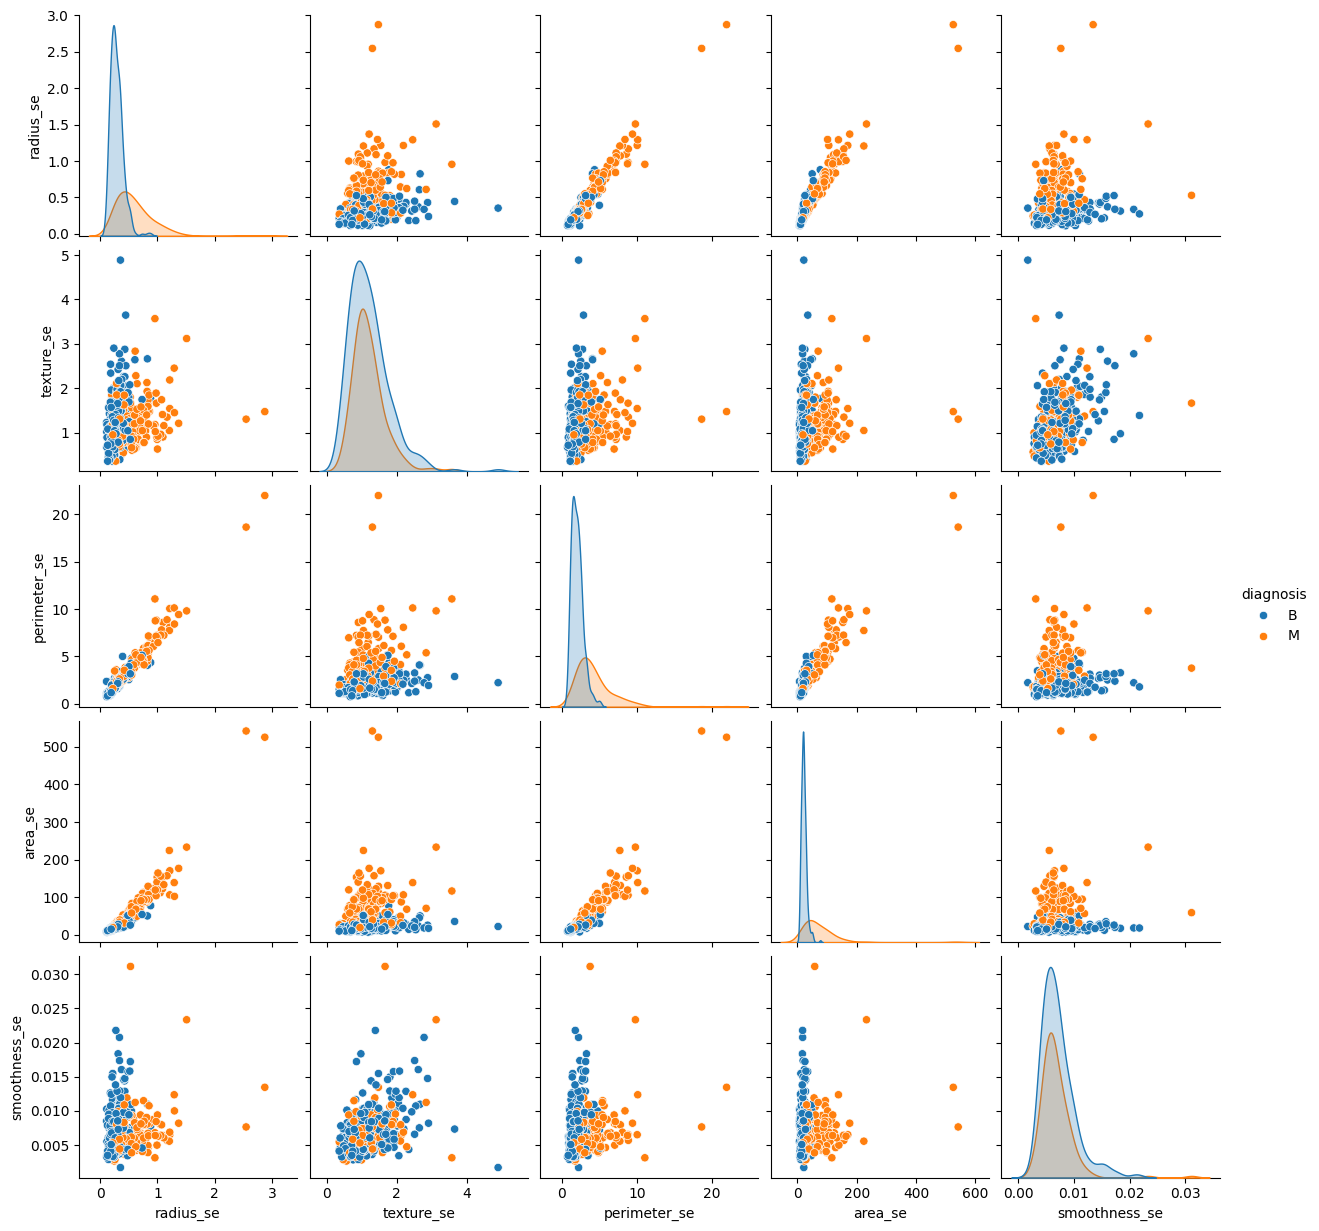

In [14]:
sns.pairplot(train_set[features_num[10:15] + [target]], hue = target)

In [15]:
to_investigate_3 = ['radius_se','perimeter_se','area_se']

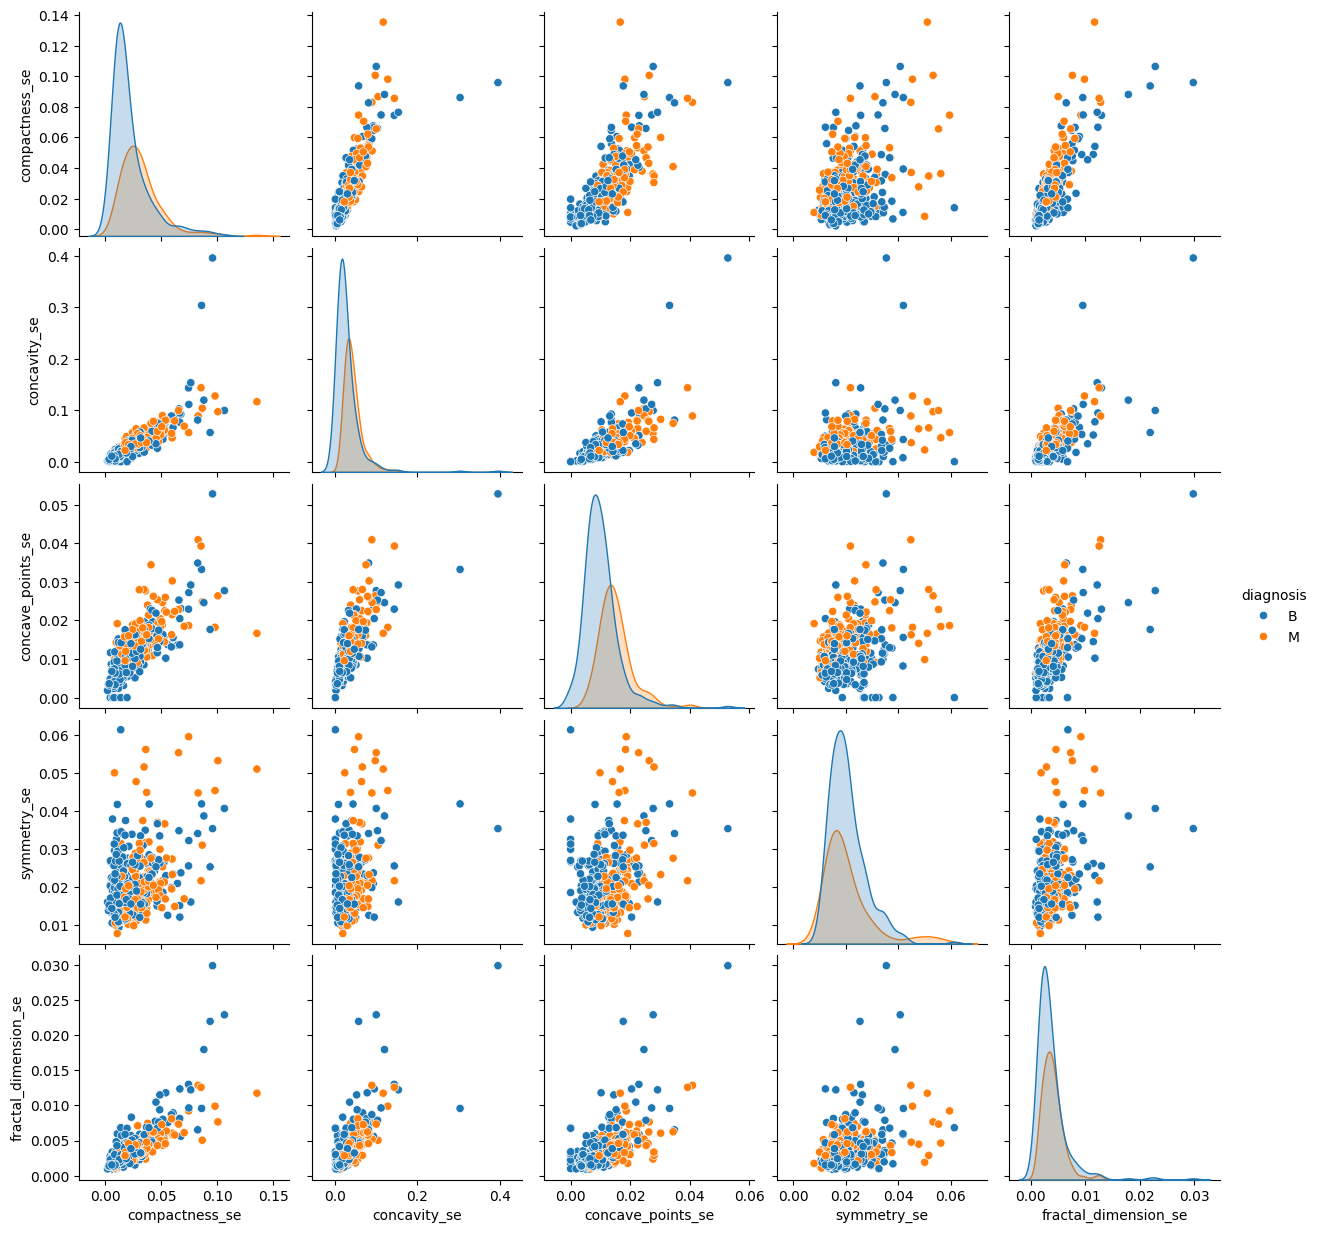

In [16]:
sns.pairplot(train_set[features_num[15:20] + [target]], hue = target)

In [17]:
to_investigate_5 = ['compactness_se', 'concavity_se','concave_points_se']

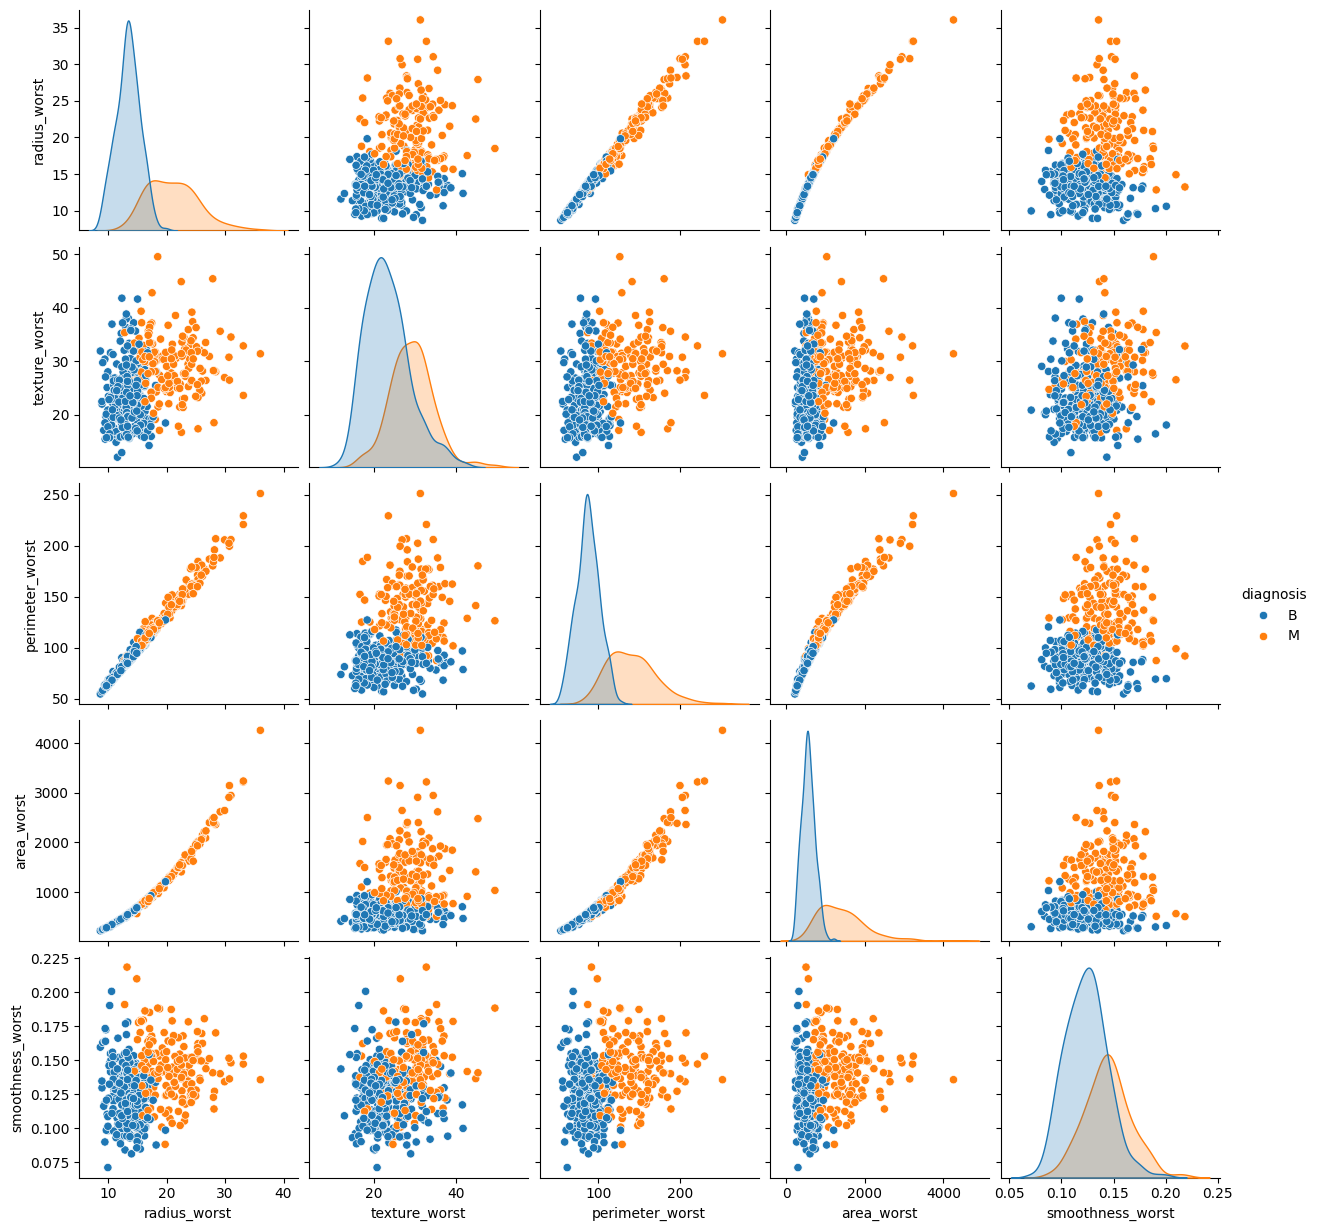

In [18]:
sns.pairplot(train_set[features_num[20:26] + [target]], hue = target)

In [19]:
to_investigate_4 = ['radius_worst', 'perimeter_worst', 'area_worst']
corr = train_set.corr(numeric_only= True)
corr[to_investigate_1+to_investigate_3 + to_investigate_4].loc[to_investigate_1+to_investigate_3 + to_investigate_4]

,radius_mean,area_mean,perimeter_mean,radius_se,perimeter_se,area_se,radius_worst,perimeter_worst,area_worst
radius_mean,1.000000,0.986609,0.997850,0.666954,0.656071,0.719478,0.969134,0.963536,0.941849
area_mean,0.986609,1.000000,0.985985,0.722728,0.710713,0.788217,0.960519,0.955701,0.959723
perimeter_mean,0.997850,0.985985,1.000000,0.680739,0.676192,0.729937,0.969620,0.969674,0.943283
radius_se,0.666954,0.722728,0.680739,1.000000,0.973560,0.951025,0.698484,0.704374,0.737451
perimeter_se,0.656071,0.710713,0.676192,0.973560,1.000000,0.937271,0.676239,0.701606,0.712575
area_se,0.719478,0.788217,0.729937,0.951025,0.937271,1.000000,0.735075,0.740394,0.793332
radius_worst,0.969134,0.960519,0.969620,0.698484,0.676239,0.735075,1.000000,0.993315,0.983458
perimeter_worst,0.963536,0.955701,0.969674,0.704374,0.701606,0.740394,0.993315,1.000000,0.976979
area_worst,0.941849,0.959723,0.943283,0.737451,0.712575,0.793332,0.983458,0.976979,1.000000


In [20]:
features_sel = ['area_mean', 'area_se', 'area_worst']

In [21]:
corr[to_investigate_2+to_investigate_5].loc[to_investigate_2+to_investigate_5]

,compactness_mean,concavity_mean,concave_points_mean,compactness_se,concavity_se,concave_points_se
compactness_mean,1.000000,0.877467,0.825932,0.724415,0.554362,0.649575
concavity_mean,0.877467,1.000000,0.914671,0.655682,0.683196,0.680136
concave_points_mean,0.825932,0.914671,1.000000,0.458476,0.413601,0.596006
compactness_se,0.724415,0.655682,0.458476,1.000000,0.802761,0.753961
concavity_se,0.554362,0.683196,0.413601,0.802761,1.000000,0.780833
concave_points_se,0.649575,0.680136,0.596006,0.753961,0.780833,1.000000


In [22]:
lista = ['compactness_mean','concave_points_mean','compactness_se','concavity_se','concave_points_se']
for col in lista:
    features_sel.append(col)

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [23]:
features_sel

['area_mean',
 'area_se',
 'area_worst',
 'compactness_mean',
 'concave_points_mean',
 'compactness_se',
 'concavity_se',
 'concave_points_se']

In [24]:
rg_lgt = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)

array([[<Axes: title={'center': 'area_mean'}>,
        <Axes: title={'center': 'area_se'}>,
        <Axes: title={'center': 'area_worst'}>],
       [<Axes: title={'center': 'compactness_mean'}>,
        <Axes: title={'center': 'concave_points_mean'}>,
        <Axes: title={'center': 'compactness_se'}>],
       [<Axes: title={'center': 'concavity_se'}>,
        <Axes: title={'center': 'concave_points_se'}>, <Axes: >]],
      dtype=object)

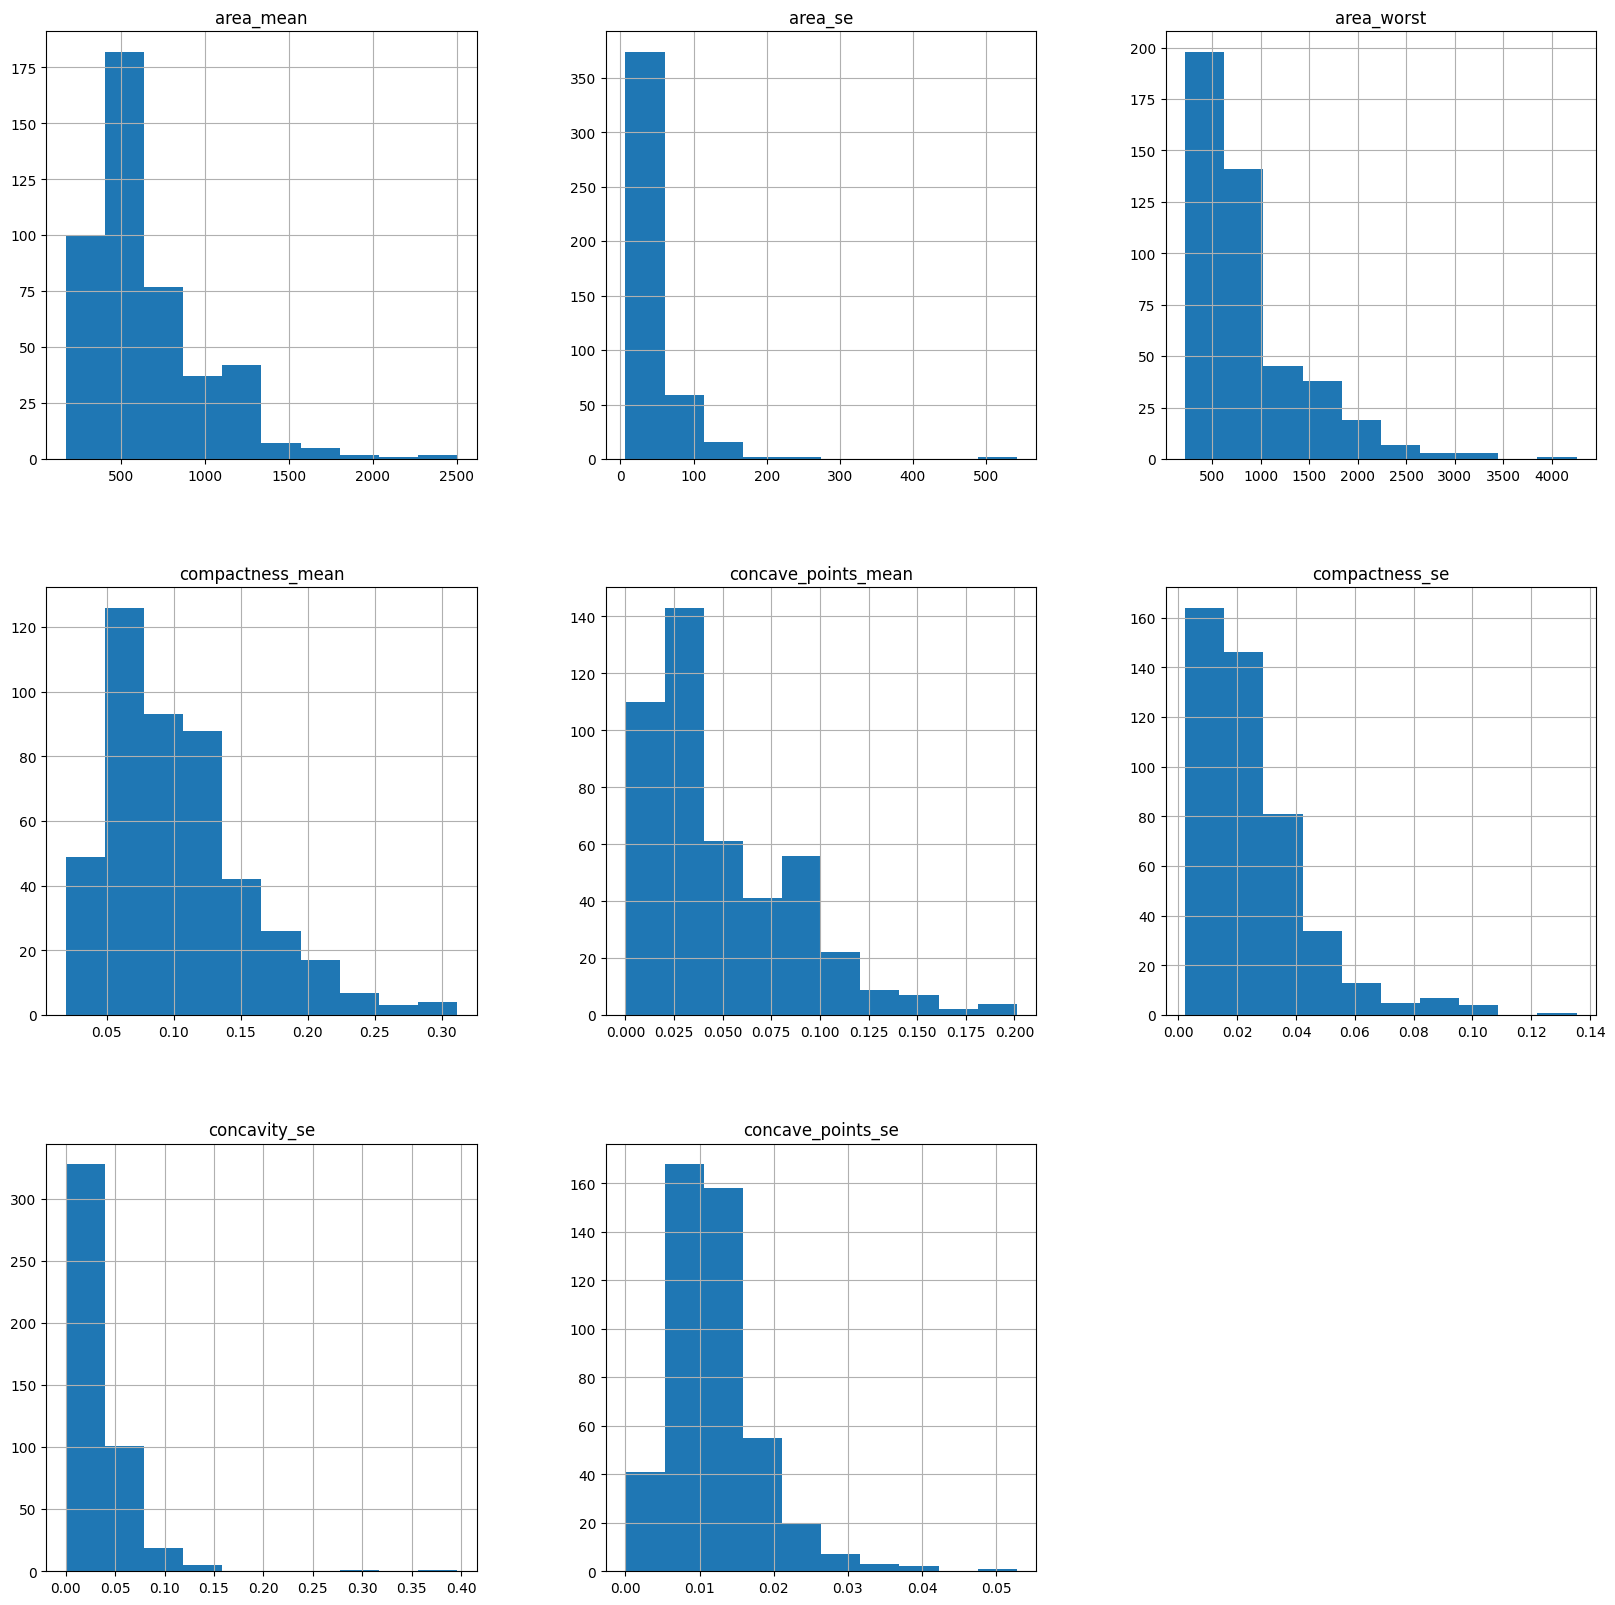

In [25]:
train_set[features_sel].hist(figsize=(20,20))

In [26]:
df[features_sel].describe()

,area_mean,area_se,area_worst,compactness_mean,concave_points_mean,compactness_se,concavity_se,concave_points_se
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,654.889104,40.337079,880.583128,0.104341,0.048919,0.025478,0.031894,0.011796
std,351.914129,45.491006,569.356993,0.052813,0.038803,0.017908,0.030186,0.006170
min,143.500000,6.802000,185.200000,0.019380,0.000000,0.002252,0.000000,0.000000
25%,420.300000,17.850000,515.300000,0.064920,0.020310,0.013080,0.015090,0.007638
50%,551.100000,24.530000,686.500000,0.092630,0.033500,0.020450,0.025890,0.010930
75%,782.700000,45.190000,1084.000000,0.130400,0.074000,0.032450,0.042050,0.014710
max,2501.000000,542.200000,4254.000000,0.345400,0.201200,0.135400,0.396000,0.052790


Hay dops columnas con valores 0 que hay que sumar un valor para poder hacerle el logaritmo como a todas las demas. Transformamos y escalamos las variables para poder hacer el regresor logistico.

In [27]:
feat_sel2 = ['concave_points_se','concave_points_mean', 'concavity_se']
feat_sel1 = []
for col in features_sel:
    if col not in feat_sel2:
        feat_sel1.append(col)

In [28]:
train_set_scaled = train_set[features_sel].copy()
test_set_scaled = test_set[features_sel].copy()

for col in feat_sel1:
    train_set_scaled[col] = np.log(train_set_scaled[col])
    test_set_scaled[col] = np.log(test_set_scaled[col])

In [33]:
dic = {'concave_points_se': [],
       'concave_points_mean': [],
       'concavity_se': []}
for col in feat_sel2:
    for x in train_set[col]:
        dic[col].append(x + 1)

In [37]:
for col in feat_sel2:
    train_set_scaled[col] = dic[col]
    train_set_scaled[col] = train_set_scaled[col].apply(np.log)
    

In [39]:
dic_test = {'concave_points_se': [],
       'concave_points_mean': [],
       'concavity_se': []}
for col in feat_sel2:
    for x in test_set[col]:
        dic_test[col].append(x + 1)

for col in feat_sel2:
    test_set_scaled[col] = dic_test[col]
    test_set_scaled[col] = test_set_scaled[col].apply(np.log)

array([[<Axes: title={'center': 'area_mean'}>,
        <Axes: title={'center': 'area_se'}>,
        <Axes: title={'center': 'area_worst'}>],
       [<Axes: title={'center': 'compactness_mean'}>,
        <Axes: title={'center': 'concave_points_mean'}>,
        <Axes: title={'center': 'compactness_se'}>],
       [<Axes: title={'center': 'concavity_se'}>,
        <Axes: title={'center': 'concave_points_se'}>, <Axes: >]],
      dtype=object)

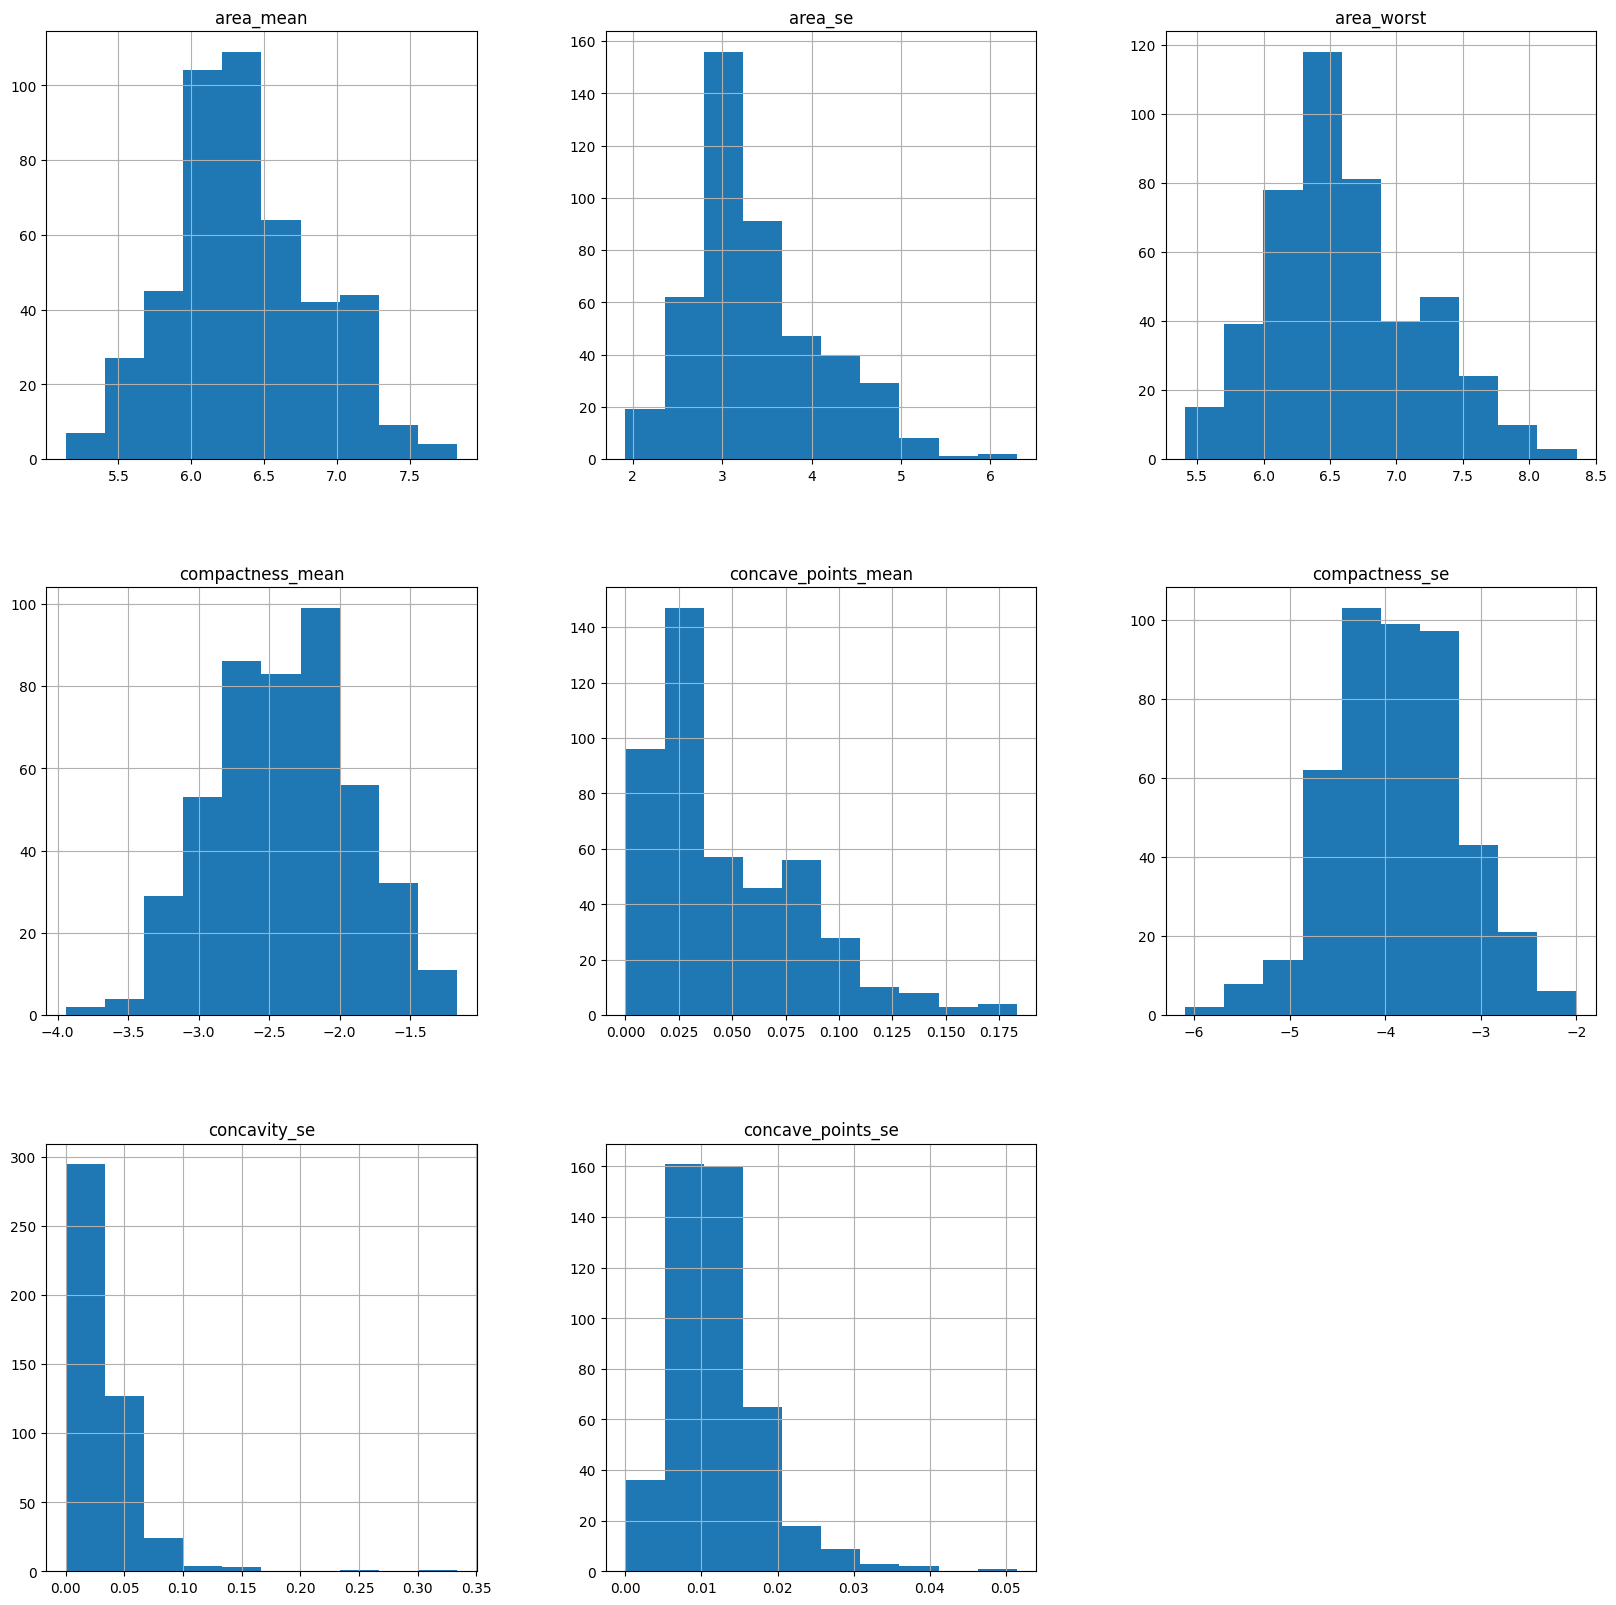

In [38]:
train_set_scaled.hist(figsize=(20,20))

In [49]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
train_set_scaled = std_scaler.fit_transform(train_set_scaled)
test_set_scaled = std_scaler.transform(test_set_scaled)


### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

In [50]:
X_train = train_set[features_sel]
y_train = train_set[target]
X_test = test_set[features_sel]
y_test = test_set[target]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(455, 8)
(114, 8)
(455,)
(114,)


### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [51]:
X_train_scaled = train_set_scaled.copy()
X_test_scaled = test_set_scaled.copy()

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(455, 8)
(114, 8)


### Ejercicio 9: Instanciación de modelos

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. Si quieres emplear la regresión logística es posible que tengas que utilizar un valor de max_iter para que el algoritmo converja.

In [52]:
rg_lgt = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)

model_names = ["LogisticRegression","Random Forest","XGBoost","LightGBM"]
model_set = [rg_lgt, rf_clf, xgb_clf, lgb_clf]

### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea el recall_medio y usa scoring = "balanced acuracy". Escoge el modelo ganador.

In [53]:
y_train = (train_set[target] == "M").astype(int) # Clase 0 -> B, Clase 1 -> M
y_test = (test_set[target] == "M").astype(int)
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    if nombre != 'LogisticRegression':
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy")
        valores.append(np.mean(metricas_cv[nombre]))
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = "balanced_accuracy")
        valores.append(np.mean(metricas_cv[nombre]))

ganador = list(metricas_cv.keys())[np.argmax(valores)]

In [54]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El ganador es {ganador}")

Model <LogisticRegression>, Accuracy_CV: 0.9087428140700267
Model <Random Forest>, Accuracy_CV: 0.9238969172886116
Model <XGBoost>, Accuracy_CV: 0.9235967015085196
Model <LightGBM>, Accuracy_CV: 0.9189011390730191
El ganador es Random Forest


### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "balance accuracy". Por otro lado, incluye en el grid, el hiperparámetro que permita que el modelo "compense" el desbalanceo del dataset de entrada, aunque este no lo tenga.

In [47]:
from sklearn.model_selection import  GridSearchCV
params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}
rf_clf = RandomForestClassifier(random_state= 42, class_weight='balanced')
rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid,
                       cv = 3,
                       scoring = "balanced_accuracy",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'min_samples_leaf': [10, 20, 40],
                         'n_estimators': [100, 200, 400]},
             scoring='balanced_accuracy')

In [57]:
rf_grid.best_score_

np.float64(0.922357978279031)

### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        71
           1       0.87      0.93      0.90        43

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



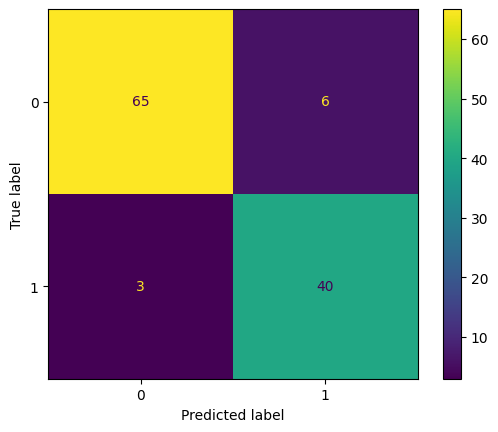

In [48]:
y_pred = rf_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Ejercicio 13: Análisis de errores

Muestra la matriz de confusión con los porcentajes de precisión (emplea ConfusionMatrixDisplay.from_predictions con el argumento normalize con el valor adecuado). Haz un pequeño análisis.

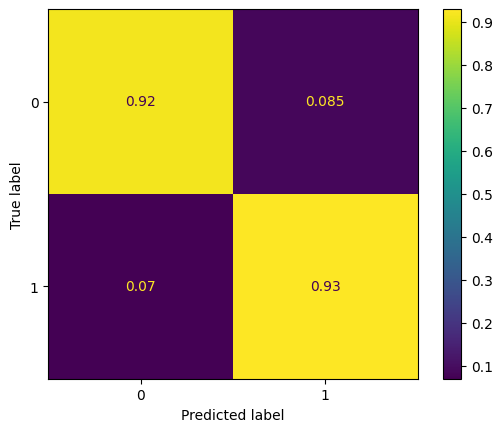

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = 'true')

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/cancer_pred" con la extesión apropiada.